
# TICA

TICA is short for Time-lagged Independent Component Analysis and is a linear transformation method that can be used for dimensionality reduction. To that end, it maps the data to the "slow" processes, i.e., it finds the coordinates of maximal autocorrelation at a given lag time $\tau$:


In [1]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import sktime
from sklearn.decomposition import PCA

In [2]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

In [3]:
rnd = np.random.RandomState(seed=17)

In [4]:
msm = sktime.markov.msm.MarkovStateModel(transition_matrix=[[0.97, 0.03], [0.03, 0.97]])

In [5]:
dtraj = msm.simulate(N=200)

In [6]:
ftraj = np.empty((len(dtraj), 2))

In [7]:
state_0_indices = np.where(dtraj == 0)[0]
state_1_indices = np.where(dtraj == 1)[0]

In [24]:
cov = [[.4, .2], [.2, .4]]

In [25]:
ftraj[state_0_indices] = rnd.multivariate_normal(mean=[0.0, 0.0], cov=cov, size=len(state_0_indices))

In [26]:
ftraj[state_1_indices] = rnd.multivariate_normal(mean=[0.0, 1.0], cov=cov, size=len(state_1_indices))

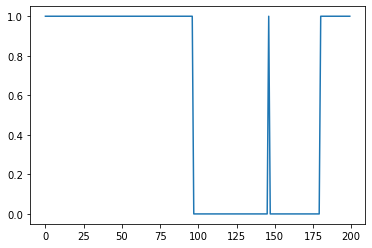

In [27]:
plt.plot(dtraj)

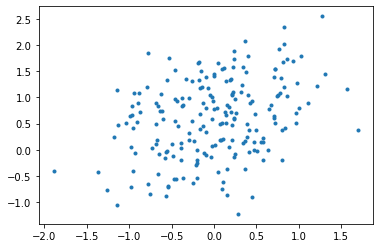

In [28]:
plt.scatter(*(ftraj.T), marker='.')

In [29]:
estimator = sktime.decomposition.TICA(lagtime=1, dim=1)
tica_model = estimator.fit(ftraj).fetch_model()
dominant_eigenvector = tica_model.eigenvectors[0]

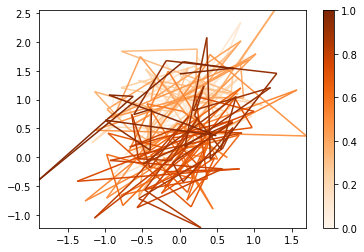

In [30]:
f, ax = plt.subplots()
lc = LineCollection(make_segments(ftraj[:, 0], ftraj[:, 1]), cmap='Oranges', norm=plt.Normalize(0.0, 1.0))
lc.set_array(np.linspace(0, 1, num=len(ftraj)))
line = ax.add_collection(lc)
f.colorbar(line, ax=ax)
plt.quiver([0], [60], [dominant_eigenvector[0]], [dominant_eigenvector[1]], scale=.1)

ax.set_xlim([np.min(ftraj[:, 0]), np.max(ftraj[:, 0])])
ax.set_ylim([np.min(ftraj[:, 1]), np.max(ftraj[:, 1])]);

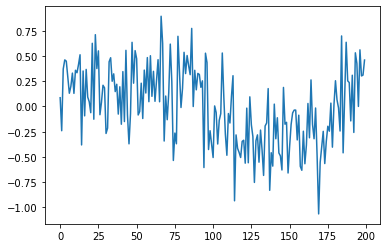

In [31]:
proj = tica_model.transform(ftraj)
plt.plot(proj);

In [32]:
pca = PCA(n_components=1).fit(ftraj)

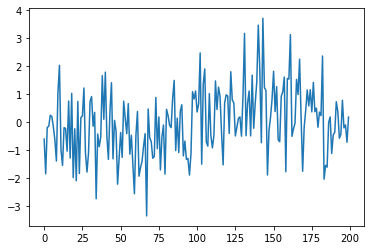

In [17]:
plt.plot(pca.transform(ftraj));